## 01. Analisis Exploratorio

- Realizado por: 
  Francisco del Val Yague, Alejandro Girón y Laura Martínez González de Aledo

- Emails: 
  francisco.delval@cunef.edu, a.garciagiron@cunef.edu y l.martinezg@cunef.edu*
  
Colegio Universitario de Estudios Financieros. CUNEF

### Objetivo:

El objetivo de este trabajo es encontrar el mejor método para predecir el consumo de energia renovable en función de la tiempo.

### Índice:

* 1. API Demanda de Energia
    * 1.1 Tratamiento de la base de datos
    * 1.2 Analisis de la Serie Temporal
        * 1.2.1 Estacionariedad
            * a) Componentes de una serie temporal.
            * b) ACF y APCF
            * c) MA
            * d) Test Dicky Fuller
            * e) Gráficos de densidad
        * 1.2.1 Estacionalidad
            * a) Boxplots
* 2. API Tiempo
    * 2.1 Tratamiento de la base de datos
* 3. Analisis de correlación
    * 3.1 Escalado
    * 3.2 Corrplots
* 4. Referencias

In [968]:
# LIBRERIAS

# Sacar APIs
import requests
import json

# Manipulacion del DataFrame
import pandas as pd
import numpy as np

# Eda
!pip install pandas-profiling 
from pandas_profiling import ProfileReport

# Series Temporales
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose

from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

# Fechas
import datetime

# Escalar
from sklearn.preprocessing import MinMaxScaler

# Graficos
import matplotlib.pyplot as plt
import seaborn as sbn

# Warnings
import warnings;
warnings.filterwarnings('ignore')

# Sin puntos suspensivos
pd.options.display.max_columns = None 
pd.options.display.max_rows = None 

En primer lugar, realizamos un request a la URL de la red eléctrica española sobre la evolución de la demanda eléctrica en España desde enero de 2016, hasta los datos disponibles del año 2020.

In [969]:
# 2020
r_20 = requests.get('https://apidatos.ree.es/es/datos/demanda/evolucion?start_date=2020-01-01T00:00&end_date=2020-12-31T22:00&time_trunc=day&geo_limit=peninsular&geo_ids=8741')

# 2019
r_19 = requests.get('https://apidatos.ree.es/es/datos/demanda/evolucion?start_date=2019-01-01T00:00&end_date=2019-12-31T22:00&time_trunc=day&geo_limit=peninsular&geo_ids=8741')

# 2018
r_18 = requests.get('https://apidatos.ree.es/es/datos/demanda/evolucion?start_date=2018-01-01T00:00&end_date=2018-12-31T22:00&time_trunc=day&geo_limit=peninsular&geo_ids=8741')

# 2017
r_17 = requests.get('https://apidatos.ree.es/es/datos/demanda/evolucion?start_date=2017-01-01T00:00&end_date=2017-12-31T22:00&time_trunc=day&geo_limit=peninsular&geo_ids=8741')

# 2016
r_16 = requests.get('https://apidatos.ree.es/es/datos/demanda/evolucion?start_date=2016-01-01T00:00&end_date=2016-12-31T22:00&time_trunc=day&geo_limit=peninsular&geo_ids=8741')

A contiuación, vamos a proceder a la normalización del fichero **.json** extraido de aplicación API:

In [970]:
# 2020
b_20=json.loads(r_20.text)
c_20=b_20['included']
d_20=c_20[0]
e_20=d_20['attributes']
f_20=e_20['values']

# 2019
b_19=json.loads(r_19.text)
c_19=b_19['included']
d_19=c_19[0]
e_19=d_19['attributes']
f_19=e_19['values']

# 2018
b_18=json.loads(r_18.text)
c_18=b_18['included']
d_18=c_18[0]
e_18=d_18['attributes']
f_18=e_18['values']

# 2017
b_17=json.loads(r_17.text)
c_17=b_17['included']
d_17=c_17[0]
e_17=d_17['attributes']
f_17=e_17['values']

# 2016
b_16=json.loads(r_16.text)
c_16=b_16['included']
d_16=c_16[0]
e_16=d_16['attributes']
f_16=e_16['values']

Generamos nuevos objetos DataFrames para poder trabajar con ellos poseriormente:

In [971]:
elect20=pd.DataFrame(f_20)
elect19=pd.DataFrame(f_19)
elect18=pd.DataFrame(f_18)
elect17=pd.DataFrame(f_17)
elect16=pd.DataFrame(f_16)

Mostramos la cabeza de cada DataFrame:

In [972]:
elect20.head()

,value,percentage,datetime
0,538863.153,1,2020-01-01T00:00:00.000+01:00
1,683023.223,1,2020-01-02T00:00:00.000+01:00
2,713955.710,1,2020-01-03T00:00:00.000+01:00
3,663458.646,1,2020-01-04T00:00:00.000+01:00
4,614448.070,1,2020-01-05T00:00:00.000+01:00


In [973]:
elect19.head()

,value,percentage,datetime
0,547404.192,1,2019-01-01T00:00:00.000+01:00
1,701784.804,1,2019-01-02T00:00:00.000+01:00
2,746345.169,1,2019-01-03T00:00:00.000+01:00
3,754085.459,1,2019-01-04T00:00:00.000+01:00
4,681461.272,1,2019-01-05T00:00:00.000+01:00


In [974]:
elect18.head()

,value,percentage,datetime
0,539925.842,1,2018-01-01T00:00:00.000+01:00
1,684961.951,1,2018-01-02T00:00:00.000+01:00
2,713422.320,1,2018-01-03T00:00:00.000+01:00
3,713027.277,1,2018-01-04T00:00:00.000+01:00
4,685084.586,1,2018-01-05T00:00:00.000+01:00


In [975]:
elect17.head()

,value,percentage,datetime
0,563412.483,1,2017-01-01T00:00:00.000+01:00
1,697414.245,1,2017-01-02T00:00:00.000+01:00
2,749672.112,1,2017-01-03T00:00:00.000+01:00
3,746635.920,1,2017-01-04T00:00:00.000+01:00
4,714384.901,1,2017-01-05T00:00:00.000+01:00


In [976]:
elect16.head()

,value,percentage,datetime
0,515581.473,1,2016-01-01T00:00:00.000+01:00
1,578184.270,1,2016-01-02T00:00:00.000+01:00
2,584378.725,1,2016-01-03T00:00:00.000+01:00
3,666565.106,1,2016-01-04T00:00:00.000+01:00
4,663020.147,1,2016-01-05T00:00:00.000+01:00


Concantenamos los dataframe de cada año para estudiar la evolución de la demanda de energía a lo largo de los últimos 5 años:

In [977]:
demanda_total = pd.concat([elect16, elect17, elect18, elect19, elect20], axis=0)

In [978]:
demanda_total.head()

,value,percentage,datetime
0,515581.473,1,2016-01-01T00:00:00.000+01:00
1,578184.270,1,2016-01-02T00:00:00.000+01:00
2,584378.725,1,2016-01-03T00:00:00.000+01:00
3,666565.106,1,2016-01-04T00:00:00.000+01:00
4,663020.147,1,2016-01-05T00:00:00.000+01:00


Convertimos la columna fecha en el formato fecha creando una nueva columna llamada *time*:

In [979]:
demanda_total['time']=pd.to_datetime(demanda_total['datetime'], format='%Y-%m-%d %H:%M:%S')

Renombramos la columna *value* y eliminando las dos columnas que no consideramos necesarias en nuestro trabajo:

In [980]:
demanda_total = demanda_total.rename(columns={'value':'demanda_energia'})

In [981]:
del demanda_total['percentage']
del demanda_total['datetime']

In [982]:
demanda_total.head()

,demanda_energia,time
0,515581.473,2016-01-01 00:00:00+01:00
1,578184.270,2016-01-02 00:00:00+01:00
2,584378.725,2016-01-03 00:00:00+01:00
3,666565.106,2016-01-04 00:00:00+01:00
4,663020.147,2016-01-05 00:00:00+01:00


A continuación vamos a dividir __time__ para poder trabajar con ella:

In [983]:
x = demanda_total['time'] # la duplicamos

In [984]:
x = x.astype(str) # convert to string

In [985]:
len(x) 

1827

In [986]:
x = x.map(lambda x: x.split(' '))

In [987]:
x.iloc[0]

['2016-01-01', '00:00:00+01:00']

In [988]:
x.max()

['2020-12-31', '00:00:00+01:00']

In [989]:
x = x.map(lambda x: x[0])

In [990]:
x

0      2016-01-01
1      2016-01-02
2      2016-01-03
3      2016-01-04
4      2016-01-05
5      2016-01-06
6      2016-01-07
7      2016-01-08
8      2016-01-09
9      2016-01-10
10     2016-01-11
11     2016-01-12
12     2016-01-13
13     2016-01-14
14     2016-01-15
15     2016-01-16
16     2016-01-17
17     2016-01-18
18     2016-01-19
19     2016-01-20
20     2016-01-21
21     2016-01-22
22     2016-01-23
23     2016-01-24
24     2016-01-25
25     2016-01-26
26     2016-01-27
27     2016-01-28
28     2016-01-29
29     2016-01-30
30     2016-01-31
31     2016-02-01
32     2016-02-02
33     2016-02-03
34     2016-02-04
35     2016-02-05
36     2016-02-06
37     2016-02-07
38     2016-02-08
39     2016-02-09
40     2016-02-10
41     2016-02-11
42     2016-02-12
43     2016-02-13
44     2016-02-14
45     2016-02-15
46     2016-02-16
47     2016-02-17
48     2016-02-18
49     2016-02-19
50     2016-02-20
51     2016-02-21
52     2016-02-22
53     2016-02-23
54     2016-02-24
55     201

Una vez la hemos dividido, la eliminamos:

In [991]:
demanda_total['time'] = x 
del x

In [992]:
demanda_total.head()

,demanda_energia,time
0,515581.473,2016-01-01
1,578184.270,2016-01-02
2,584378.725,2016-01-03
3,666565.106,2016-01-04
4,663020.147,2016-01-05


Realizamos un analisis de los principales estadísticos:

In [993]:
demanda_total.describe(include='all')

,demanda_energia,time
count,1827.000000,1827
unique,NaN,1827
top,NaN,2016-08-21
freq,NaN,1
mean,679551.175166,NaN
std,68726.061314,NaN
min,473279.908000,NaN
25%,630375.046500,NaN
50%,683023.223000,NaN
75%,732838.767500,NaN


In [994]:
profiling = ProfileReport(elect16)
profiling 

Comprobamos que nuestro dataframe no tiene valores nulos:

In [995]:
demanda_total.isnull().sum()

demanda_energia    0
time               0
dtype: int64

A continuación mostramos las fechas seleccionadas para realizar nuestro trabajo:

In [996]:
print('Time period start: {}\nTime period end: {}'.format(demanda_total.time.min(),demanda_total.time.max()))

Time period start: 2016-01-01
Time period end: 2020-12-31


Convertimos la columna __time__ a formato fecha:

In [997]:
demanda_total['time'] = pd.to_datetime(demanda_total['time'], format='%Y-%m-%d')

Y la establecemos como indice:

In [998]:
demanda_total = demanda_total.set_index('time')

Por último, guardamos nuestra serie temporal en un archivo CSV para trabajar con ella posteriormente:

In [999]:
demanda_total.to_csv('../data/02_intermediate/demanda_energia_2016-2020.csv', index = None, header=True)

# Serie Temporal

Antes de realizar cualquier EDA, debemos estudiar la estacionariedad de nuestra serie temporal, sus componentes y la autocorrelación parcial.    

## Estacionariedad

En primer lugar, estudiamos la estacionariedad de nuestra serie temporal. Se dice que es estrictamente estacionaria si sus propiedades no son afectadas por los cambios a lo largo del tiempo. Es decir, que se deberían cumplir tres criterios básicos para poder considerar a una series de tiempo como estacionaria:

__1. La media de la serie no debe ser una función de tiempo;__ sino que debe ser constante. La siguiente imagen muestra una serie que cumple con esta condición y otra que no la cumple.

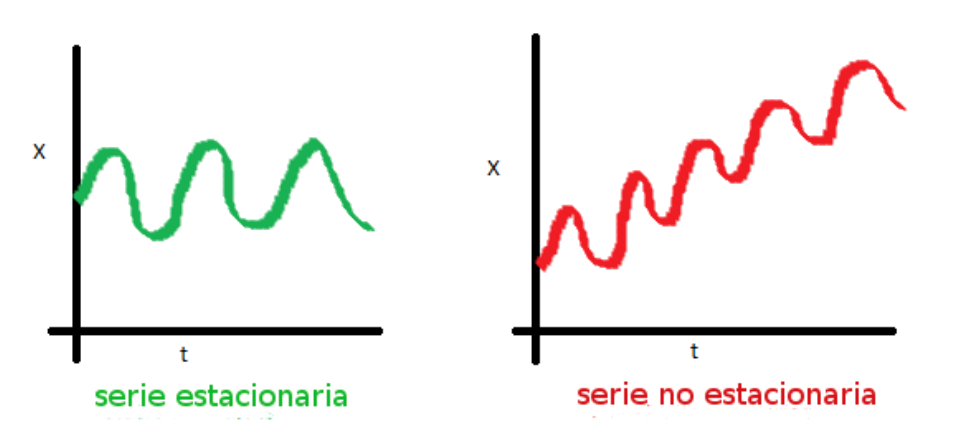

__2. La varianza de la serie no debe ser una función del tiempo.__ El siguiente gráfico representa una serie cuya varianza no esta afectada por el tiempo (es estacionaria) y otra que no cumple con esa condición.

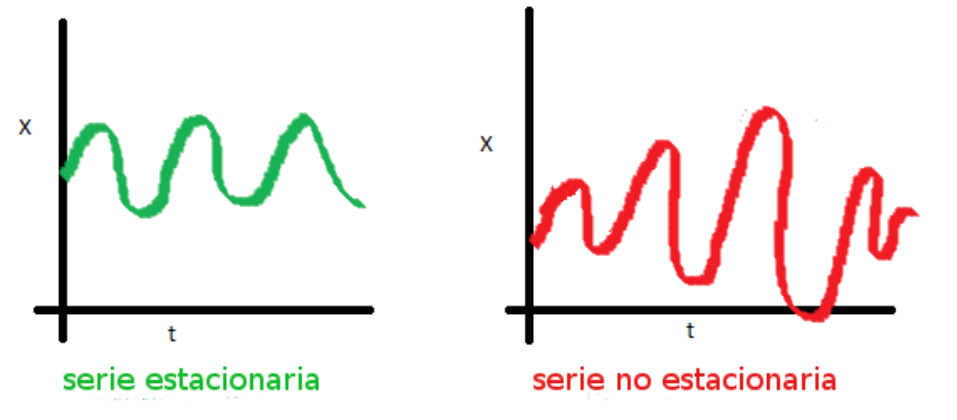

__3. La covarianza de la serie no debe ser una función del tiempo.__ En el gráfico de la derecha, se puede observar que la propagación de la serie se va encogiendo a medida que aumenta el tiempo. Por lo tanto, la covarianza no es constante en el tiempo para la serie roja.

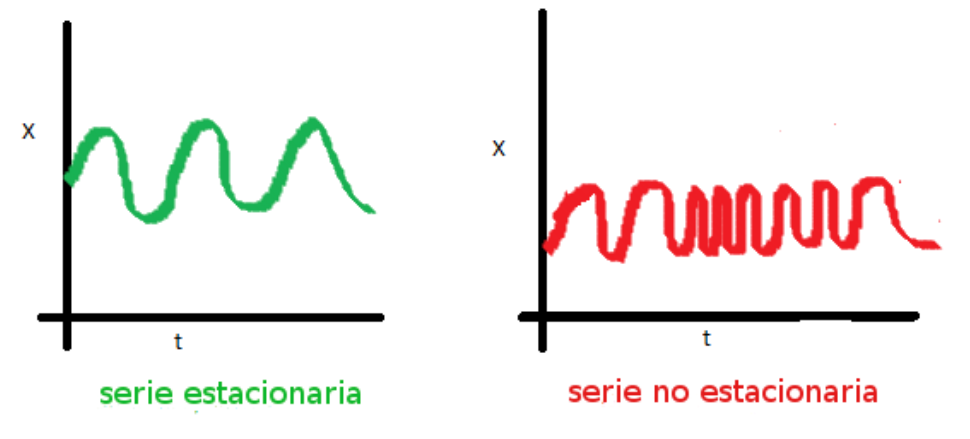

In [1000]:
demanda16 = demanda_total['demanda_energia']['2016-01-01':'2016-12-31']
demanda17 = demanda_total['demanda_energia']['2017-01-01':'2017-12-31']
demanda18 = demanda_total['demanda_energia']['2018-01-01':'2018-12-31']
demanda19 = demanda_total['demanda_energia']['2019-01-01':'2019-12-31']
demanda20 = demanda_total['demanda_energia']['2020-01-01':'2020-12-30']

Text(0.5, 0.98, 'Demanda de energía eléctrica en España 2016-2020')

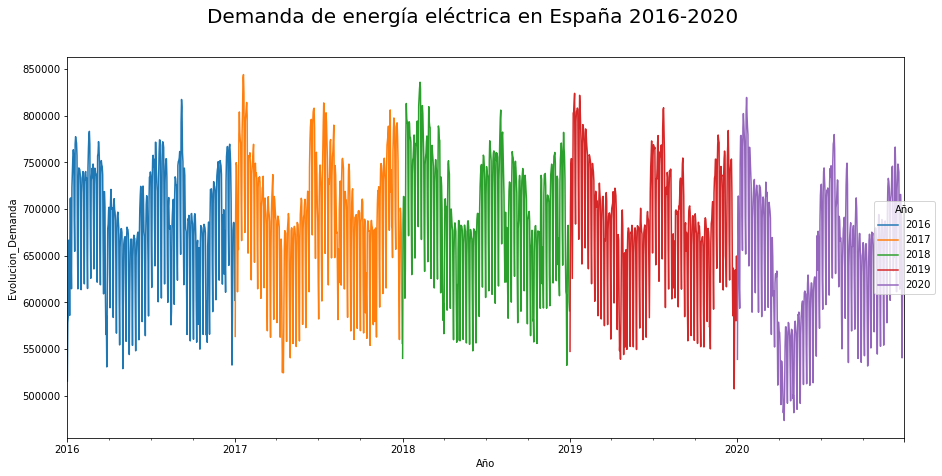

In [1001]:
pd.plotting.register_matplotlib_converters()

fig, ax1=plt.subplots(figsize=(15,7))

demanda16.plot(label='2016')
demanda17.plot(label='2017')
demanda18.plot(label='2018')
demanda19.plot(label='2019')
demanda20.plot(label='2020')

ax1.set_xlabel("Año")
ax1.set_ylabel("Evolucion_Demanda")
ax1.legend(loc='center', title='Año', bbox_to_anchor=(1, 0.5))
fig.suptitle('Demanda de energía eléctrica en España 2016-2020', fontsize=20)

#### Transformación Logaritmica:

Podemos aplicar transformaciones que penalicen los valores más altos más que los valores más pequeños, de manera que comprendamos de mejor manera nuestro conjunto de datos.

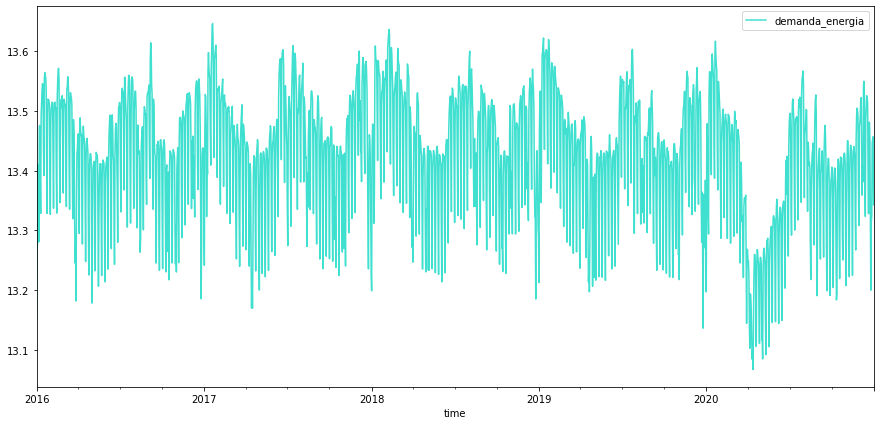

In [1002]:
color = ['turquoise']
demanda_total_log = np.log(demanda_total.astype('float64'))
demanda_total_log.plot(color=color, figsize=(15,7))

Podemos obervar como se trata de una serie temporal no estacionaria caracterizada por una caida considerable en el consumo de energía en el segundo trimestre del año en curso debido a que la crisis sanitaria mundial que está teniendo lugar tuvo como consecuencia un aislamiento de la población en España en ese trimestre.

### Componentes de los datos de una serie temporal: 

* __Tendencia__ un aumento o disminución a largo plazo de los datos se denomina tendencia. No tiene porque ser necesariamente lineal. Es el patrón subyacente en los datos a lo largo del tiempo. 

* __Estacional__ cuando una serie está influenciada por factores estacionales, es decir, un trimestre del año, mes o días de una semana, la estacionalidad existe en la serie. Siempre es de un período fijo y conocido. P.ej. – Un aumento repentino en las ventas durante el verano, etc.     

* __Cíclico__ cuando los datos muestran subidas y caídas que no son del período fijo, lo llamamos patrón cíclico. Por ejemplo – La duración de estas fluctuaciones suele ser de al menos 2 años.

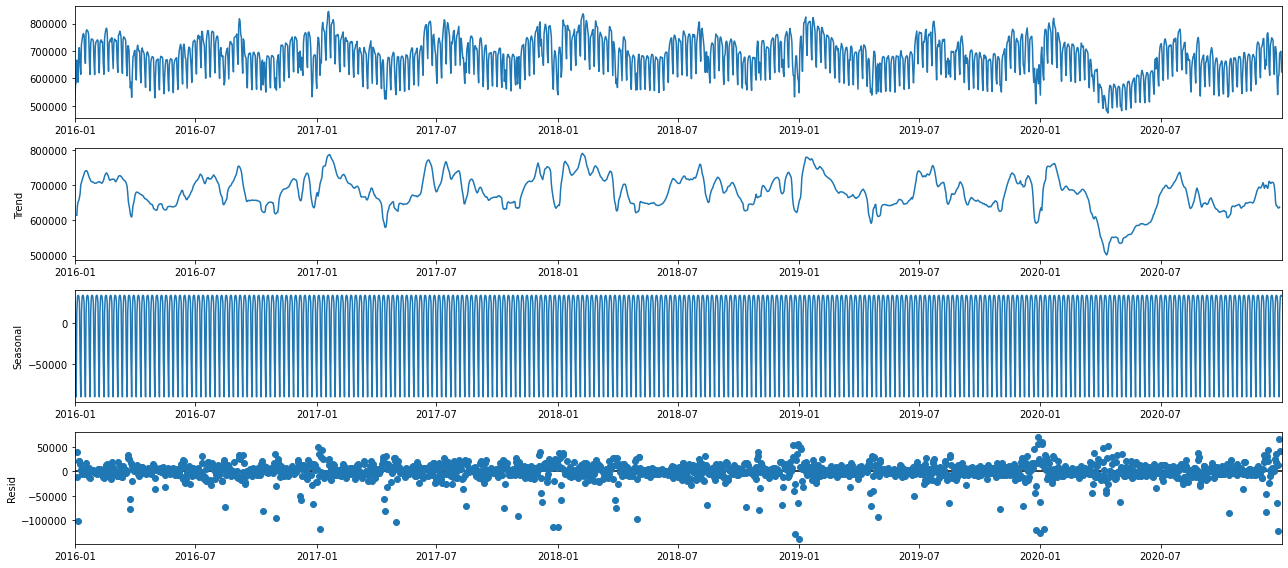

In [1003]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(demanda_total, model='additive')
fig = decomposition.plot()
plt.show()

Con el grafico anterior podemos descubrir si los datos satisfacen todos los supuestos del modelado ARIMA, principalmente, la estacionariedad y la estacionalidad.

También podemos comprobar la estacionariedad con los siguientes métodos:

#### 1.  ACF y PACF:

Repasemos los gráficos de la función de autocorrelación (ACF) y la función de autocorrelación parcial (PACF).

PACF es la autocorrelación parcial, elimina efectos indirectos es decir, lo que pasó hoy está relacionado con lo de ayer y lo de ayer con lo de antes de ayer. Por lo que lo que pasó hoy está relacionado con lo que pasó antes de ayer de forma indirecta.

Si nuestra serie temporal fuera estacionaria, las gráficas de ACF / PACF mostrarán una caída rápida en la correlación después de una pequeña cantidad de retraso entre los puntos.

De forma predeterminada, se establece en un intervalo de confianza del 95%, lo que sugiere que los valores de correlación fuera de este código son muy probablemente una correlación y no una casualidad estadística.

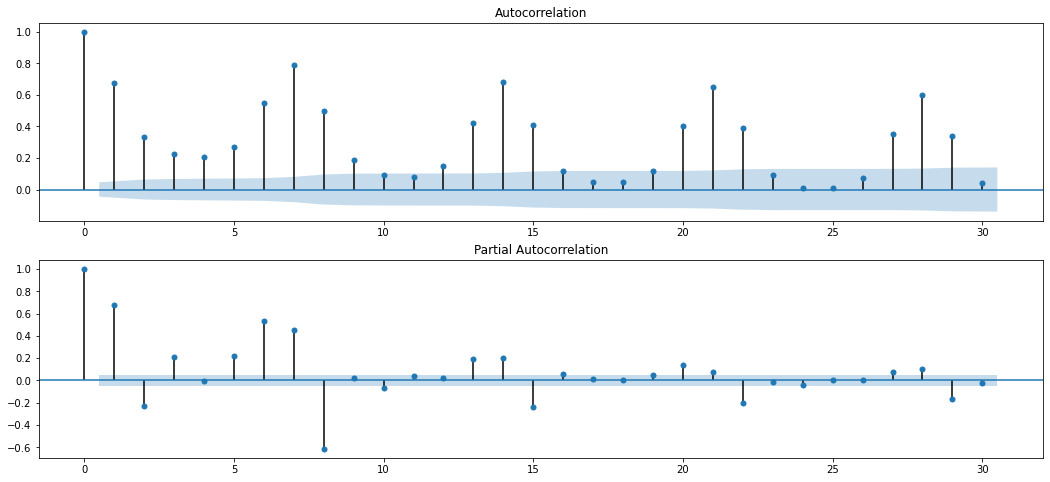

In [1004]:
plt.figure()
plt.subplot(211)
plot_acf(demanda_total.demanda_energia, ax=plt.gca(), lags = 30)
plt.subplot(212)
plot_pacf(demanda_total.demanda_energia, ax=plt.gca(), lags = 30)
plt.show()

En los gráficos anteriores, obervamos que la variación no es ruido blanco por lo que tendremos que forzar un modelo que haga la diferencia estacional (d=1) y no regular (D=1) para poder estimar correctamente un modelo autoregresivo estacional.

#### 2. MA:

Podemos representar la media móvil o la varianza móvil y ver si varía con el tiempo. La media móvil ó varianza para cualquier instante "t", coincide con la media ó varianza del último año es decir, los últimos 12 meses.

Text(0.5, 0.98, 'Demanda de energía eléctrica en España 2016-2020')

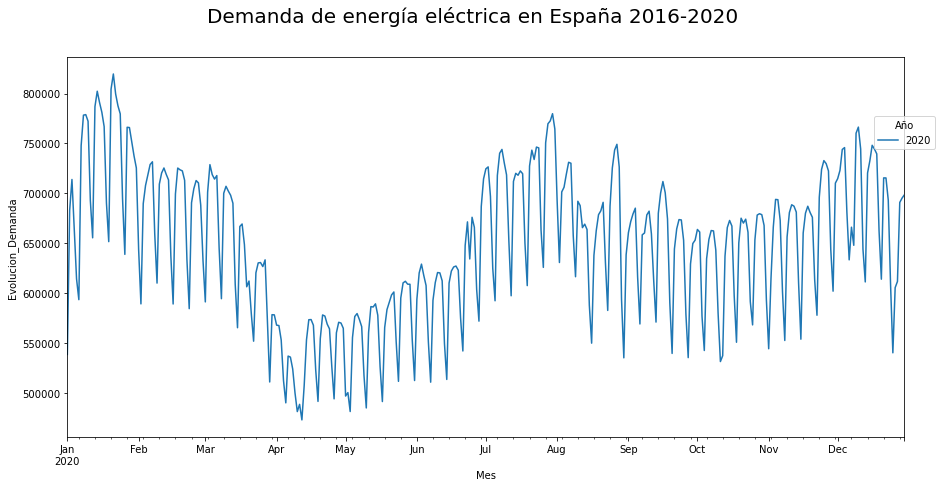

In [1005]:
pd.plotting.register_matplotlib_converters()

fig, ax1=plt.subplots(figsize=(15,7))

demanda20.plot(label='2020')

ax1.set_xlabel("Mes")
ax1.set_ylabel("Evolucion_Demanda")
ax1.legend(loc='center', title='Año', bbox_to_anchor=(1, 0.8))
fig.suptitle('Demanda de energía eléctrica en España 2016-2020', fontsize=20)

Observamos que la media móvil y la desviación estándar no son constantes con respecto al tiempo, no sigue una tendencia . Por tanto, la serie temporal no es estacionaria

#### 3. Test Dickey-Fuller Aumentado:

Se trata de un test de contraste de hipotesis para verificar la estacionariedad. Aquí la hipótesis nula es que nuestra serie temporal no es estacionaria. Por lo tanto, se acepta la hipotesis nula por que __p-valor < 0.05__.

In [1006]:
print ('Test Dickey-Fuller:')
dftest = adfuller(demanda_total.demanda_energia, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test estadístico','p-valor','Retrasos aplicados','Numero de observaciones'])
for key,value in dftest[4].items():
    dfoutput['Valor Crítico (%s)'%key] = value
print (dfoutput)

Test Dickey-Fuller:
Test estadístico             -4.672333
p-valor                       0.000095
Retrasos aplicados           21.000000
Numero de observaciones    1805.000000
Valor Crítico (1%)           -3.433978
Valor Crítico (5%)           -2.863143
Valor Crítico (10%)          -2.567623
dtype: float64


### Gráficos de densidad:

Revisamos los gráficos de densidad debido a que nos aporta una mayor compresión en la estructura de nuestros datos.

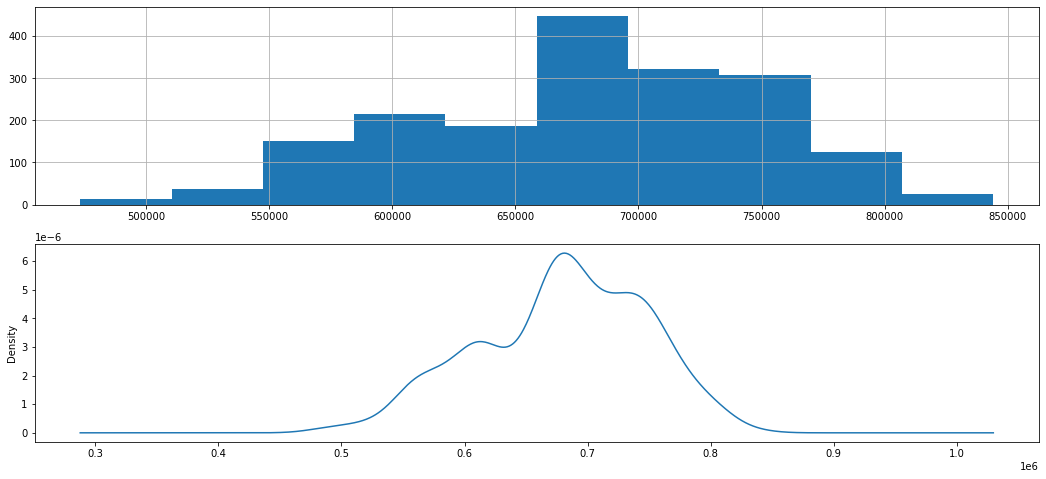

In [1007]:
plt.figure(1)
plt.subplot(211)
demanda_total.demanda_energia.hist()
plt.subplot(212)
demanda_total.demanda_energia.plot(kind='kde')
plt.show()

Podemos afirmar lo siguiente:
* La distribución no es perfectamente gaussiana (distribución normal).
* La distribución se desplaza a la derecha.
* Las transformaciones pueden resultar útiles ante de realizar modelos de predicción.

## Estacionalidad

A continuación, se profundizará en la estacionalidad de los datos con diagramas de caja, utilizando la función boxplot() de seaborn para agrupar los datos por diferentes períodos de tiempo y mostrar las distribuciones de cada año.

A continuación, se agruparán las series temporales de consumo de electricidad por día de la semana, para explorar la estacionalidad a lo largo de los cinco años.

Estos diagramas confirman la estacionalidad anual que se observó en las gráficas anteriores.

__Box and Whisker Plots:__
* Median values across years confirms an upwards trend
* Steady increase in the spread, or middle 50% of the data (boxes) over time
* A model considering seasonality might work well

In [1008]:
demanda_total['Año'] = demanda_total.index.year                                
demanda_total['Mes'] = demanda_total.index.month                               
demanda_total['Dia'] = demanda_total.index.weekday  
demanda_total.head()

,demanda_energia,Año,Mes,Dia
time,,,,
2016-01-01,515581.473,2016,1,4
2016-01-02,578184.270,2016,1,5
2016-01-03,584378.725,2016,1,6
2016-01-04,666565.106,2016,1,0
2016-01-05,663020.147,2016,1,1


Modificamos la columna *Dia* para que nos devuelva los días de la semana:

In [1009]:
# creamos un diccionario de dias
dias = {0 : 'Lunes', 1 : 'Martes', 2 : 'Miercoles', 3 : 'Jueves', 4 : 'Viernes', 5 : 'Sabado', 6 : 'Domingo'}

# y hacemos sustiuimos los valores haciendo un replace y creando una columna nueva
demanda_total['Dia'] = demanda_total['Dia'].replace(dias)

Modificamos la columna *Mes* para que nos devuelva los meses del año:

In [1010]:
# creamos un diccionario de meses
meses = {1 : 'Enero', 2 : 'Febrero', 3 : 'Marzo', 4 : 'Abril', 5 : 'Mayo', 6 : 'Junio', 7 : 'Julio', 8 : 'Agosto', 9 : 'Septiembre', 10 : 'Octubre', 11 : 'Noviembre', 12 : 'Diciembre'}

# y hacemos sustiuimos los valores haciendo un replace y creando una columna nueva
demanda_total['Mes'] = demanda_total['Mes'].replace(meses)

In [1011]:
demanda_total.head()

,demanda_energia,Año,Mes,Dia
time,,,,
2016-01-01,515581.473,2016,Enero,Viernes
2016-01-02,578184.270,2016,Enero,Sabado
2016-01-03,584378.725,2016,Enero,Domingo
2016-01-04,666565.106,2016,Enero,Lunes
2016-01-05,663020.147,2016,Enero,Martes


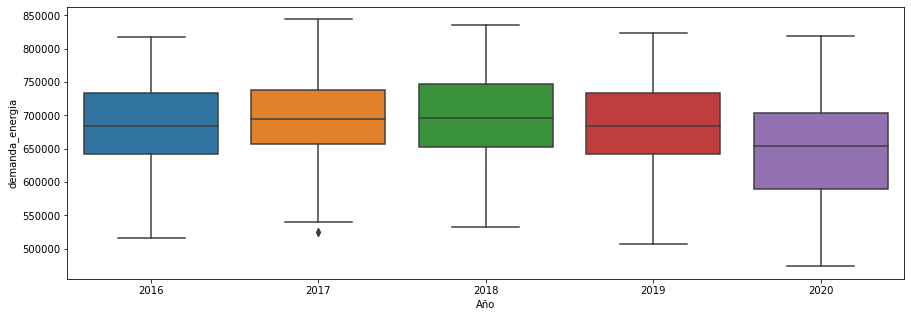

In [1012]:
fig, ax = plt.subplots(figsize=(15,5))
sbn.boxplot(data=demanda_total, x='Año', y='demanda_energia')

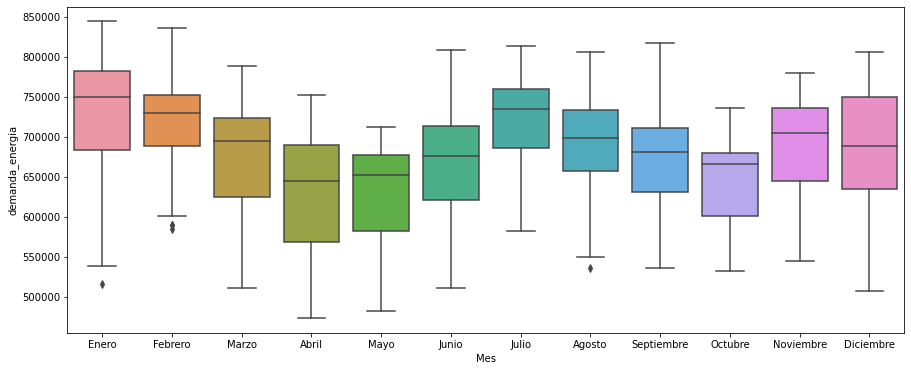

In [1013]:
fig, ax = plt.subplots(figsize=(15,6))
sbn.boxplot(data=demanda_total, x='Mes', y='demanda_energia')

Podemos ver que el consumo de electricidad es generalmente más alto en invierno y más bajo en verano, la mediana y los dos cuartiles más bajos son más bajos en diciembre y enero en comparación con noviembre y febrero, probablemente debido a que las empresas están cerradas durante las vacaciones. Esto se observó en la serie temporal del año 2016, y el diagrama de caja confirma que este es un patrón constante a lo largo de los años.

A continuación, se agruparán las series temporales de consumo de electricidad por día de la semana, para explorar la estacionalidad semanal.

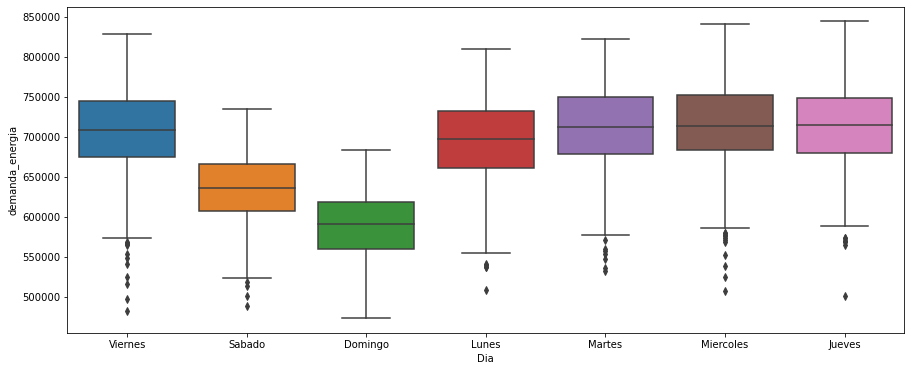

In [1014]:
fig, ax = plt.subplots(figsize=(15,6))
sbn.boxplot(data=demanda_total, x='Dia', y='demanda_energia')

Como se esperaba, el consumo de electricidad es significativamente mayor en los días de semana que en los fines de semana. Los valores atípicos bajos en los días de semana son probablemente durante los días festivos.

### Variable Exógena

Como última parte de nuestro analisis exploratorio nos ha resultado interesante incluir una variable exógena, el tiempo expresado en grados Fahrenheit, para ver si éste está relacionado con el consumo de energía.

En primer lugar, hemos obtenido los datos realizando un request a la URL de _NOAA_. 

In [1015]:
# 2020
r_tiempo20 = requests.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&locationid=CITY:SP000006&stationid=GHCND:SPE00120278'
                          '&startdate=2020-01-01&enddate=2020-12-31', headers={
                                                  'Token':'OalYYcFONZPZofbOBNaORKeAbpIhEAfP'})

# 2019
r_tiempo19 = requests.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&locationid=CITY:SP000006&stationid=GHCND:SPE00120278'
                          '&startdate=2019-01-01&enddate=2019-12-31&limit=1000&offset=1', headers={
                                                  'Token':'OalYYcFONZPZofbOBNaORKeAbpIhEAfP'})

# 2018
r_tiempo18 = requests.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&locationid=CITY:SP000006&stationid=GHCND:SPE00120278'
                          '&startdate=2018-01-01&enddate=2018-12-31&limit=1000&offset=1', headers={
                                                  'Token':'OalYYcFONZPZofbOBNaORKeAbpIhEAfP'})

# 2017
r_tiempo17 = requests.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&locationid=CITY:SP000006&stationid=GHCND:SPE00120278'
                          '&startdate=2017-01-01&enddate=2017-12-31&limit=1000&offset=1', headers={
                                                  'Token':'OalYYcFONZPZofbOBNaORKeAbpIhEAfP'})

# 2016
r_tiempo16 = requests.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&locationid=CITY:SP000006&stationid=GHCND:SPE00120278'
                          '&startdate=2016-01-01&enddate=2016-12-31&limit=1000&offset=1', headers={
                                                  'Token':'OalYYcFONZPZofbOBNaORKeAbpIhEAfP'})

In [1016]:
# 2020
a_tiempo20=json.loads(r_tiempo20.text)
b_tiempo20=a_tiempo20['results']

## 2019
a_tiempo19=json.loads(r_tiempo19.text)
b_tiempo19=a_tiempo19['results']

## 2018
a_tiempo18=json.loads(r_tiempo18.text)
b_tiempo18=a_tiempo18['results']

## 2017
a_tiempo17=json.loads(r_tiempo17.text)
b_tiempo17=a_tiempo17['results']

## 2016
a_tiempo16=json.loads(r_tiempo16.text)
b_tiempo16=a_tiempo16['results']

In [1017]:
tiempo20=pd.DataFrame(b_tiempo20)
tiempo19=pd.DataFrame(b_tiempo19)
tiempo18=pd.DataFrame(b_tiempo18)
tiempo17=pd.DataFrame(b_tiempo17)
tiempo16=pd.DataFrame(b_tiempo16)

In [1018]:
tiempo = pd.concat([tiempo20, tiempo19, tiempo18, tiempo17, tiempo16], axis=0)

In [1019]:
tiempo.head()

,date,datatype,station,attributes,value
0,2020-01-01T00:00:00,PRCP,GHCND:SPE00120278,",,E,",0
1,2020-01-01T00:00:00,TAVG,GHCND:SPE00120278,"H,,S,",33
2,2020-01-01T00:00:00,TMAX,GHCND:SPE00120278,",,E,",128
3,2020-01-01T00:00:00,TMIN,GHCND:SPE00120278,",,E,",-21
4,2020-01-02T00:00:00,PRCP,GHCND:SPE00120278,",,E,",0


In [1020]:
tiempo['time']=pd.to_datetime(tiempo['date'], format='%Y-%m-%d %H:%M:%S')

In [1021]:
del tiempo['station']
del tiempo['attributes']
del tiempo['date']

Como la columna _datatype_ devuelve muchos resultados, hemos decididio quedarnos con la temperatura media de cada dia ( _TAVG_ ):

In [1022]:
tiempo['datatype'].value_counts()

PRCP    1008
TAVG    1007
TMIN    1005
TMAX    1005
Name: datatype, dtype: int64

In [1023]:
tiempo['datatype'] = np.where((tiempo['datatype'] == 'TAVG'), 'temperatura media', 'otros')

In [1024]:
tiempo2 = tiempo[(tiempo.datatype == 'temperatura media')] 

In [1025]:
del tiempo2['datatype']

Tratamos la columna _time_ :

In [1026]:
tiempo3 = tiempo2.rename(columns={'value':'grados_fahrenheit'})

In [1027]:
tiempo = tiempo3.set_index('time')

Guardamos la base de datos del tiempo en un archivo plano csv:

In [1034]:
tiempo.to_csv('../data/02_intermediate/tiempo_2016-2020.csv', index=True, header=True)

Una vez tratada la base de datos sobre el tiempo, la concatenamos a la tabla de la evolución de la demanda para estudiar la relación que tiene:

In [1029]:
datos = pd.merge(demanda_total, tiempo, on='time')

In [1030]:
datos.head()

,demanda_energia,Año,Mes,Dia,grados_fahrenheit
time,,,,,
2016-01-01,515581.473,2016,Enero,Viernes,106
2016-01-02,578184.270,2016,Enero,Sabado,91
2016-01-03,584378.725,2016,Enero,Domingo,68
2016-01-04,666565.106,2016,Enero,Lunes,127
2016-01-05,663020.147,2016,Enero,Martes,79


### Escalar:

Procedemos a escalar nuestra variables de manera que podamos compararlas correctamente:

In [1031]:
datos_numericos = datos[['demanda_energia', 'grados_fahrenheit']]
escalar = MinMaxScaler()
escalados = escalar.fit_transform(datos_numericos)
datos_escalados = pd.DataFrame(escalados, index = datos_numericos.index, columns = datos_numericos.columns)

A continuación, comprobamos que el consumo de energía se ve afectado por la temperatura media:

Text(0, 0.5, 'Consumo de energía')

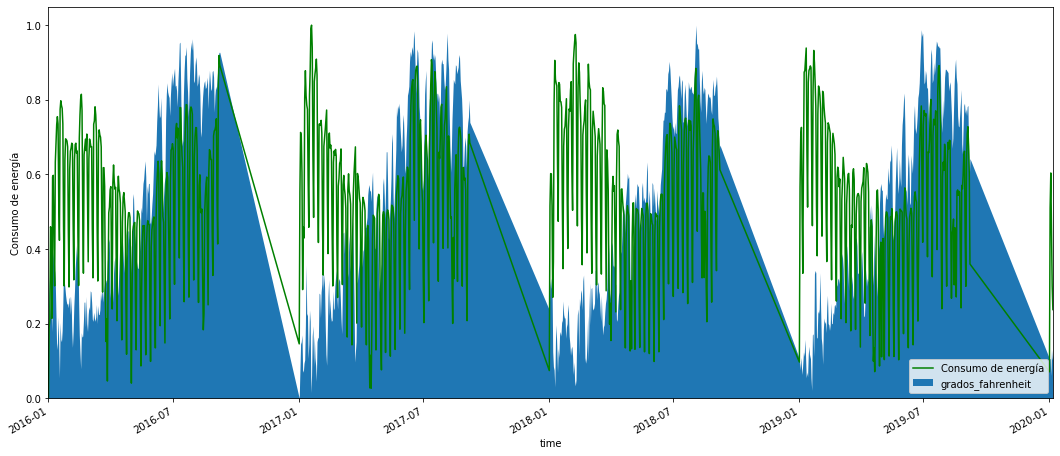

In [1032]:
fig,eje = plt.subplots()
eje.plot(datos_escalados['demanda_energia'],color='green',label='Consumo de energía')
datos_escalados[['grados_fahrenheit']].plot.area(ax=eje,linewidth=0)
eje.legend()
eje.set_ylabel('Consumo de energía')


Como podemos observar en el gráfico, que cuando la temperatura, medida en grados fahrenheit, alcanza su valor mínimo y máximo es cuando se produce un aumento significante en el consumo de energía debido a el uso de calefacción en los meses más fríos y al uso del aire acondicionado en los meses de verano.

In [1035]:
datos_escalados.to_csv('../data/02_intermediate/datos_2016-2020.csv', index=True, header=True)

### Referencias:

* Demanda Energia *https://www.ree.es/es*


* Estacionariedad *https://relopezbriega.github.io/blog/2016/09/26/series-de-tiempo-con-python/*


* Estacionalidad *https://unipython.com/analisis-de-series-temporales-con-la-libreria-pandas/*


* Tiempo *https://www.noaa.gov*
